In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp


# GMM done easy

moment eqn fn gets a $n \times k$ matrix of residuals (implied by the moment condition) and minimizes the implied objective function.
Uses implicit gradient (and therefore performs better than `scipy.optimize.minimize`).

In [2]:
from jaxopt import LevenbergMarquardt
from tqdm import tqdm
from joblib import Parallel, delayed

jax.config.update("jax_enable_x64", True)


In [3]:
# IV dataset
np.random.seed(42)
def dgp(b = np.array([1, 2]), N = 1_000, K = 3):
    # Instruments
    Z = np.random.normal(0, 1, (N, K))
    # Covariates
    pi = np.random.uniform(1, 2, K)
    w = Z @ pi + np.random.normal(0, 1, N) # endogenous treatment
    X = np.c_[np.ones(N), w]
    # Outcome
    y = X @ b + np.random.normal(0, 1, N)
    return {"y": y, "X": X, "Z": Z}


In [4]:
@jax.jit
def moment_cond(b, dat):
    y, X, Z = jnp.array(dat['y']), jnp.array(dat['X']), jnp.array(dat['Z'])
    resid = y - X @ b
    return jnp.array(Z * resid[:, None])

def solve_gmm(dat):
    x_init = jnp.zeros(dat['X'].shape[1])
    gn = LevenbergMarquardt(moment_cond)
    return gn.run(x_init, dat = dat).params

solve_gmm(dgp())


Array([0.97738733, 2.00528897], dtype=float64)

In [5]:
%%time
def gmmsim():
    df = dgp()
    return solve_gmm(df)

res = Parallel(n_jobs = -1)(delayed(gmmsim)() for _ in tqdm(range(1000)))
res = np.array(res)


 61%|██████    | 608/1000 [00:47<00:33, 11.76it/s]/home/alal/anaconda3/envs/metrics/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]


CPU times: user 4.53 s, sys: 509 ms, total: 5.04 s
Wall time: 1min 29s


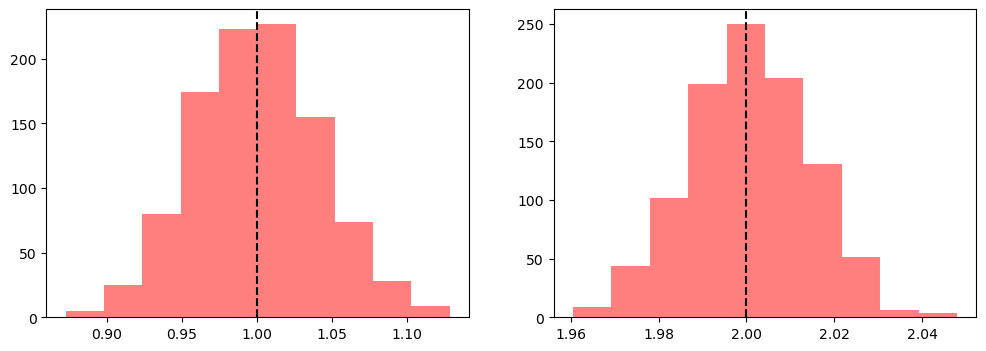

In [6]:
f, ax = plt.subplots(1, 2, figsize = (12, 4))
# Plot histogram of the 'intercept' column
ax[0].hist(np.array(res[:, 0]), color='red', alpha=0.5)
ax[0].axvline(x=1, color='black', linestyle='--', label='True Value')

# Plot histogram of the 'slope' column
ax[1].hist(np.array(res[:, 1]), color='red', alpha=0.5)
ax[1].axvline(x=2, color='black', linestyle='--', label='True Value')

plt.show()


## balancing weights

solve dual of ERM problem for exact balance. For details, see [Wang and Zubizarreta](http://jrzubizarreta.com/minimal.pdf)

In [7]:
from jaxopt import LBFGS
import empirical_calibration as ec
import matplotlib.pyplot as plt


In [13]:
@jax.jit
def eb_moment(b, X0, X1):
    return jnp.log(jnp.exp(-1 * X0 @ b).sum()) + X1 @ b

def ebwt(X0, X1):
    init_par = jnp.repeat(1., X0.shape[1])
    solver = LBFGS(fun=eb_moment, maxiter=100)
    res = solver.run(init_par, X0 = X0, X1 = X1)
    wt = np.exp(-1 * X0 @ res.params)
    wt /= wt.sum()
    return wt


In [14]:
# kang shafer 2007 dgp
def onesim():
    sim = ec.data.kang_schafer.Simulation(size=1000)
    w, y, X = sim.treatment, sim.outcome, np.c_[np.repeat(1, 1000), sim.covariates]
    X0, X1 = X[w == 0, :], X[w == 1, :].mean(0)
    wt = ebwt(X0, X1)
    naive = y[w == 1].mean() - y[w == 0].mean()
    wtd = y[w == 1].mean() - np.average(y[w == 0], weights=wt)
    return naive, wtd

onesim()


(-23.606203882367566, 0.16018810178724152)

In [15]:
%%time
res = Parallel(n_jobs=-1)(delayed(onesim)() for _ in tqdm(range(1_000)))


 21%|██        | 208/1000 [00:57<04:08,  3.19it/s]/home/alal/anaconda3/envs/metrics/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1000/1000 [05:28<00:00,  3.05it/s]


CPU times: user 5.8 s, sys: 1.86 s, total: 7.66 s
Wall time: 5min 40s


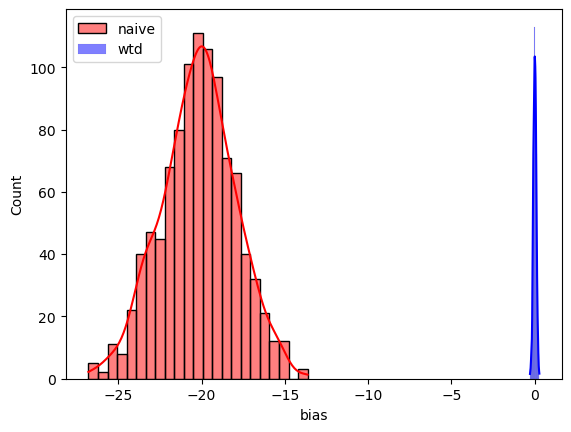

In [16]:
simres = pd.DataFrame(res, columns = ['naive', 'wtd'])

sns.histplot(simres['naive'], color = 'red', alpha = 0.5, kde = True,
             label = 'naive')
sns.histplot(simres['wtd'], color = 'blue', alpha = 0.5, kde = True,
             label = 'wtd')
plt.xlabel('bias')
plt.legend()
